# Find a vacation destination using multi modal Agent 

## Multi modal Agents

In this notebook we will demonstrate how to create multi modal agents, which can process input images alongwith textual information. 

## Scenario

In this example we are going to create an Agent that will have access to tools to find a vacation destination. You will be able to ask this agent questions, watch it call the required tools, and have conversations with it.

Create an agent to find vacation destination based on image uploaded by the user. This agent will extract activities and city from the image and then use  this information to suggest suitable travel destination.

<img src="multi-modal.jpg" alt="image" style="width:800px;height:auto;"/>

## Setup

Let's start with installing required packages. 

In [1]:
# %pip install -U langchain-community langgraph langchain-chroma langchain_aws pandas  ipywidgets pillow

For observability you can use LangSmith. You need to sign up and use the API Key.  

In [2]:
import logging
from dotenv import load_dotenv

In [3]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

Now create Bedrock client that is used to configure LLM in LangChain to use Bedrock.

In [4]:
from langchain_aws import ChatBedrock
# import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
# bedrock_client = boto3.client("bedrock-runtime", region_name="ap-northeast-1")

## Tools

Let's create tools that will be used by our agents to find a vacation destination based on user' profile and travel history of similar users.

Tools are external resources, services, or APIs that an LLM agent can access and utilize to expand its capabilities and perform specific tasks. These supplementary components allow the agent to go beyond its core language processing abilities, enabling it to interact with external systems, retrieve information, or execute actions that would otherwise be outside its scope. By integrating tools, LLM agents can provide more comprehensive and practical solutions to user queries and commands.

We will create a tool that uses historic travel information of different users to find a vacation destination based on user' profile and travel history of similar users. The tool will use the local csv file to retrieve historical data about travel destinations. It will then analyze the data and return the most popular destination for the user.



We will use LangChain Tools to create tools that are used by our agents. These are utilities designed to be called by a model: their inputs are designed to be generated by models, and their outputs are designed to be passed back to models. Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

A tool consists of:

- The name of the tool.
- A description of what the tool does.
- A JSON schema defining the inputs to the tool.
- A function (and, optionally, an async variant of the function)

When a tool is bound to a model, the name, description and JSON schema are provided as context to the model. Given a list of tools and a set of instructions, a model can request to call one or more tools with specific inputs. 

In [31]:
import pandas as pd
from collections import Counter
from langchain_core.tools import tool


def read_travel_data(file_path: str = "synthetic_travel_data.csv") -> pd.DataFrame:
    """Read travel data from CSV file"""
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return pd.DataFrame(
            columns=[
                "Name",
                "Current_Location",
                "Age",
                "Past_Travel_Destinations",
                "Number_of_Trips",
                "Flight_Number",
                "Departure_City",
                "Arrival_City",
                "Flight_Date",
            ]
        )


@tool
def compare_and_recommend_destination(name: str) -> str:
    """This tool is used to check which destinations user has already traveled. 
    Use name of the user to fetch the information about that user.
    If user has already been to a city then do not recommend that city. 
    
    Args:
        name (str): Name of the user.
    Returns:
        str: Destination to be recommended.
    
    """

    df = read_travel_data()

    if name not in df["Name"].values:
        return "User not found in the travel database."

    user_data = df[df["Name"] == name].iloc[0]
    current_location = user_data["Current_Location"]
    age = user_data["Age"]
    past_destinations = user_data["Past_Travel_Destinations"].split(", ")

    # Get all past destinations of users with similar age (±5 years) and same current location
    similar_users = df[
        (df["Current_Location"] == current_location)
        & (df["Age"].between(age - 5, age + 5))
    ]
    all_destinations = [
        dest
        for user_dests in similar_users["Past_Travel_Destinations"].str.split(", ")
        for dest in user_dests
    ]

    # Count occurrences of each destination
    destination_counts = Counter(all_destinations)

    # Remove user's current location and past destinations from recommendations
    for dest in [current_location] + past_destinations:
        if dest in destination_counts:
            del destination_counts[dest]

    if not destination_counts:
        return f"No new recommendations found for users in {current_location} with similar age."

    # Get the most common destination
    recommended_destination = destination_counts.most_common(1)[0][0]

    return f"Based on your current location ({current_location}), age ({age}), and past travel data, we recommend visiting {recommended_destination}."

In [34]:
print(compare_and_recommend_destination("Stephen Walker"))

Based on your current location (Honolulu), age (20.0), and past travel data, we recommend visiting Key West.


In [35]:
tools = [compare_and_recommend_destination]

## Language Model

Let's learn how to use a LLM with tools. 

To integrate LLM from Amazon Bedrock, we are going to use `ChatBedrockConverse` class of LangChain. We also need to use `bedrock_client` to connect to Bedrock.

In [36]:
from langchain_aws import ChatBedrockConverse

llm = ChatBedrockConverse(
    # model="anthropic.claude-3-sonnet-20240229-v1:0",
    model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    # max_tokens=None,
    # client=bedrock_client,
    # other params...
)

In [37]:
llm_with_tools = llm.bind_tools(tools)

## Agent State

The main type of graph in langgraph is the StateGraph. This graph is parameterized by a state object that it passes around to each node. Each node then returns operations to update that state.

In this example we want each node to just add messages to the message list. Therefore, we will use a TypedDict with one key (messages) and annotate it so that the messages attribute is always added to.

In [38]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes

We now need to define a few different nodes in our graph. In LangGraph, nodes are typically python functions.There are two main nodes we need for this:

The agent: responsible for deciding what (if any) actions to take.
A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

## Edges

Edges define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In [39]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation

Let's add chatbot node to the graph. It is a python function, which invokes the model. 

The `add_messages` function in our State will append the llm's response messages to whatever messages are already in the state.

In [40]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fulfill user requests.
    1. If you do not have enough inputs to execute a tool then you can ask for more information.
    2. If user has uploaded image and 'image_processing_node' has returned city and activity then use that information to call 'chatbot'
    """
    # Filter out messages with image type
    # text_messages = [msg for msg in state["messages"] if msg['content'][0].get("type") != "image"]
    text_messages = [
        msg for msg in state["messages"] 
        if not (isinstance(msg.content, list) and msg.content[0].get("type") == "image_url")
    ]

    # Invoke LLM with only text messages
    return {"messages": [llm_with_tools.invoke(text_messages)]}


graph_builder.add_node("chatbot", chatbot)

We need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node. We can use langgraph's `ToolNode` for this.  

In [41]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

Now we need to define a conditional edge that routes to the tools node when the tools are called in the llm response. We define our own custom function to handle routing or we can use `tools_condition` class of LangGraph. 

In [42]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)


We need to add a node that can handle images. 

In [43]:
def process_image_input(state):
    """
    Process image input. This tool will return activity shown in this image. 
    """
    last_message = state["messages"][-1].content[0]
    input_image = last_message['image_url']['url']
    print(input_image)
    message = HumanMessage(
        content=[
            {"type": "text", "text": "Which activity is shown in this image?"},
            {
                "type": "image_url",
                # "image_url": {"url": {input_image}},
                "image_url": {"url": f"data:image/jpeg;base64,{input_image}"},
            },
        ],
    )
    response = llm.invoke([message])
    print(response.content)
    output = {
        "messages": [
            HumanMessage(
                content=f"Image information: {response.content}", name="image_description"
            )
        ],
    }
    return output

In [44]:
graph_builder.add_node("image_processing_node", process_image_input)

In [45]:
def is_image_node(state):
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, "content") and isinstance(last_message.content, list):
        for item in last_message.content:
            if isinstance(item, dict) and item.get("type") == "image_url":
                return True
    return False

Let's add other edges and compile the graph. We can add an entry point. This tells our graph where to start its work each time we run it. We add edges to go from tools node to chatbot. 

We first check if the previous message was an image, then we pass that image through the image processing node and then we pass the output of this node back into the chatbot node.

## Memory

Above agent does not remeber previous conversations. We can add memory to our agent by passing checkpointer. When passing in a checkpointer, we also have to pass in a `thread_id` when invoking the agent (so it knows which thread/conversation to resume from).

In [46]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [47]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("image_processing_node", "chatbot")
graph_builder.add_conditional_edges(START, is_image_node, {True: "image_processing_node", False:"chatbot"})

graph = graph_builder.compile(checkpointer=memory)

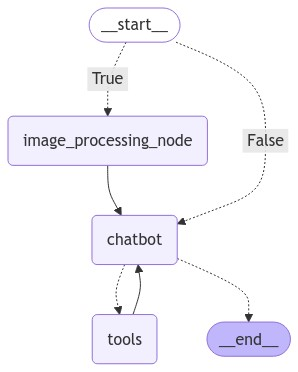

In [48]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
from IPython.display import display, clear_output
from PIL import Image
import io
import ipywidgets as widgets
import base64

In [50]:
class ImageUploader:
    def __init__(self):
        self.img_data = None
        self.img_str = None
        self.img_format = None

        self.uploader = widgets.FileUpload(
            accept="image/*",  # Accept all image types
            multiple=False,  # Allow only single file upload
        )
        self.uploader.observe(self.process_image, names="value")

    def process_image(self, change):
        clear_output(wait=True)  # Clear previous output
        if change["new"]:  # Check if there's a new file uploaded
            # Get the image data
            self.img_data = change["new"][0][
                "content"
            ]  # Access the first (and only) file

            # Open the image using PIL
            img = Image.open(io.BytesIO(self.img_data))

            # Display the image
            display(img)

            # Print image information
            print(f"Image size: {img.size}")
            print(f"Image format: {img.format}")
            print(f"Image mode: {img.mode}")

            # Store the image format
            self.img_format = img.format

            # Convert image to base64
            buffered = io.BytesIO()
            img.save(buffered, format=self.img_format)
            self.img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

            print("\nBase64 representation of the image:")
            print(
                self.img_str[:100] + "..." + self.img_str[-100:]
            )  # Print first and last 100 characters
            print(f"\nTotal length of base64 string: {len(self.img_str)} characters")

    def display_uploader(self):
        display(self.uploader)
        print("Upload an image to see its information and base64 representation.")

    def get_base64_string(self):
        return self.img_str

    def get_image_format(self):
        return self.img_format

In [51]:
# Create an instance of ImageUploader
uploader = ImageUploader()

In [53]:
# Display the upload widget
uploader.display_uploader()

FileUpload(value=(), accept='image/*', description='Upload')

Upload an image to see its information and base64 representation.


In [54]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "21"}}
message = HumanMessage(
    content=[
        {
            "type": "image_url",
            "image_url": {"url": uploader.img_str},
        },
    ],
)
print(graph.invoke({"messages": message}, config)["messages"][-1].content)

UklGRhjSAgBXRUJQVlA4IAzSAgCQIwedASraA4oDPm0ylEckIyImqbXqSNANiU1p1RtD6Ri7fV548gHeilW999BvfPzjvUeql0N5RHhwyFMAbI5BAnDpH32vf2LykOcfj//P4u3nv929gD+V+bV/p92d4b/g+wV5jGam4T6BX/X5WfnVXKe+yXwgi55v8ov1H5j7vvn9/y9mH0n/d8ur4nv1/9/1W/3P/kfu38BX9v9Bf/w/ef3tf3j/2+pX+z/839yveP/9H7re8n/GeoP/Z/+964H/0////2+Fb/N/+7///+r4J/3V/+/n3/D9/gf/n+9fu+/+D//+wB///bh/gH//6e/zH/3eeT6H/if8T7c/R38q+l/zP95/y//I/xH7lfcd+ef7f+e8gHuf9X/2f9J/uPYT+efkP91/i/3j/y3vf/2v85+Wfpr+ffvf/N/xn+l/9P+e+QX8v/n/+s/vX+Y/9P+R9/P6z/0/6b/e+Orrn+r/8/+j/13uF+yv1f/lf4L/P/tv74303/V/0v+w9m/1v/If9v/L/6r9u/sB/nv9n/6X+T9s/+D+3f7/+lr+D/3/7afAH/R/7//7f9D/wf3P+lb/G/+n+v/3/7ye8L9M/2X/x/1/+++Q3+gf4X/x/5rh1P3sLCZMPxX4YbIAeS8Mr+c5/CrREDOMUGkuweFOkMYWHeLBZHHlf4NwZFXFnATFo9HXu3SY+xvJL8Fqikw2+HAq98OJE0uqKgRVHu7solvT7BbSSXZTlel6rewYE4KtvPBEmKKtx+nEpRwQVURHaRyqgiKlzjpCa1NciEjj9v6WqTwWxS15/uJHlWVVwjWRRmRdu/S6U6mOAfOqKHvGLlRMH6TgjNdP9778RbtETqAPWzLlXsdrCOOVjJOYzdGl34sEf+tTT1zGavaDOoXtjfYK6ukfE0RZb8OsSwDSOT1zPE3uX37GfqK2nWZF3LQltdlRShchNlLCxduGEOtKiWi7ordNF29gMF2d

In [55]:
print(
    graph.invoke(
        {
            "messages": [
                (
                    "user",
                    "Stephen Walker",
                )
            ]
        },
        config,
    )["messages"][-1].content
)

Thank you for that information, Stephen. Based on your travel history and current location in Honolulu, the tool has recommended Key West as a destination for you to consider.

Key West is quite different from Ho Chi Minh City that we were initially discussing, but it offers its own unique charm and experiences. Here's some information about Key West that might interest you:

1. Location: Key West is the southernmost point of the continental United States, located at the tip of the Florida Keys.

2. Climate: Like Honolulu, Key West has a tropical climate, so you'll find warm temperatures year-round.

3. Attractions:
   - Duval Street: Known for its vibrant nightlife, restaurants, and shops.
   - Ernest Hemingway Home and Museum: The famous author's residence, now a museum.
   - Southernmost Point Buoy: A popular photo spot marking the southernmost point of the continental U.S.
   - Fort Zachary Taylor State Park: Great for beach activities and snorkeling.

4. Activities:
   - Water spo

## Conclusion

This notebook demonstrates the power and flexibility of multimodal agents using LangChain and LangGraph. We've successfully created an agent that can

- Process image inputs to extract visual information about activities and locations
- Combine visual and textual information to make personalized travel recommendations.
  
Key takeaways:
- Multimodal agents can handle diverse input types, enhancing their ability to understand and interact with users in more natural ways
- The integration of image processing capabilities allows the agent to extract valuable information from visual data, complementing text-based interactions
- By combining tools for image analysis, data retrieval, and language understanding, we've created a more comprehensive and context-aware travel recommendation system
- The modular structure of the agent, using LangGraph, allows for easy expansion and modification of capabilities as needed